In [12]:
import numpy as np
import cv2, operator
from matplotlib import pyplot as plt
from glob import glob

def show(img):
    plt.figure(figsize=(8, 6), dpi=80)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
def white_balance(img):
    result = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result = cv2.cvtColor(result, cv2.COLOR_LAB2BGR)
    return result

def clockwise_corners(corners):
    corners_ordered = sorted(corners, key=lambda x: x[0]+x[1])
    ret = []
    ret.append(corners_ordered[0])
    corners_ordered = sorted(corners_ordered[1:], key=lambda x: x[1])
    ret.append(corners_ordered[0])
    corners_ordered = sorted(corners_ordered[1:], key=lambda x: -x[0]-x[1])
    ret.append(corners_ordered[0])
    ret.append(corners_ordered[1])
    return ret

def warpBox(image,
            box,
            target_height=None,
            target_width=None,
            return_transform=False):
    """Warp a boxed region in an image given by a set of four points into
    a rectangle with a specified width and height. Useful for taking crops
    of distorted or rotated text.
    Args:
        image: The image from which to take the box
        box: A list of four points starting in the top left
            corner and moving clockwise.
        target_height: The height of the output rectangle
        target_width: The width of the output rectangle
        return_transform: Whether to return the transformation
            matrix with the image.
    """
    box = np.float32(clockwise_corners(box))
    w, h = image.shape[1], image.shape[0]
    assert (
        (target_width is None and target_height is None)
        or (target_width is not None and target_height is not None)), \
            'Either both or neither of target width and height must be provided.'
    if target_width is None and target_height is None:
        target_width = w
        target_height = h
    M = cv2.getPerspectiveTransform(src=box, dst=np.array([[0, 0], [target_width, 0], [target_width, target_height], [0, target_height]]).astype('float32'))
    full = cv2.warpPerspective(image, M, dsize=(int(target_width), int(target_height)))
    if return_transform:
        return full, M
    return full

import scipy.ndimage as ndimage

def get_tile_corners(mask):
    canny = cv2.Canny(mask, 100, 255, 1)
    corners = cv2.goodFeaturesToTrack(canny, 30, 0.1, 100)
    corners = [tuple(corner.flatten()) for corner in corners]
    tile_center = ndimage.center_of_mass(mask)
    tile_center = tuple(np.round(tile_center).astype(np.int))
    
    def distance(c1, c2):
        return (c1[0]-c2[0]) ** 2 + (c1[1]-c2[1]) ** 2
    
    lt, rt, rb, lb = tile_center, tile_center, tile_center, tile_center
    lt_d, rt_d, rb_d, lb_d = 0, 0, 0, 0
    for corner in corners:
        if corner[0] < tile_center[0] and corner[1] < tile_center[1] and distance(corner, tile_center) > lt_d:
            lt = corner
            lt_d = distance(corner, tile_center)
        if corner[0] < tile_center[0] and corner[1] > tile_center[1] and distance(corner, tile_center) > rt_d:
            rt = corner
            rt_d = distance(corner, tile_center)
        if corner[0] > tile_center[0] and corner[1] > tile_center[1] and distance(corner, tile_center) > rb_d:
            rb = corner
            rb_d = distance(corner, tile_center)
        if corner[0] > tile_center[0] and corner[1] < tile_center[1] and distance(corner, tile_center) > lb_d:
            lb = corner
            lb_d = distance(corner, tile_center)
    return np.array([lt, rt, rb, lb], dtype=int)

def get_warp_image(img, margin=9):
    orig_width = len(img[0])
    orig_height = len(img)
    target = 800
    scale = target/orig_width if orig_height > orig_width else target/orig_height

    resized = cv2.resize(img, None, fx=scale, fy=scale)
    img_balanced = white_balance(resized)
    blurred = blur(img_balanced)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    edges = cv2.threshold(s, 15, 255, cv2.THRESH_BINARY_INV)[1]

    contour_info = [(c, cv2.contourArea(c),) for c in cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)[0]]
    mask = np.zeros(list(map(operator.add, edges.shape, (margin*2,margin*2,0))), dtype = np.uint8)
    for contour in contour_info:
        mask = cv2.fillConvexPoly(mask, contour[0]+margin, (255))
    corners = get_tile_corners(mask)
    corners = [tuple((corner-margin)/scale) for corner in corners]
    
    return warpBox(img,corners)

def blur(img, filter_size=9):
    return cv2.GaussianBlur(img, (filter_size, filter_size), 0)

img_paths = glob("input/*.jpg")

In [13]:
img_path = "input/IMG_3852_boundary.png"
img_path = img_paths[0]

img = cv2.imread(img_path)
img_warped = get_warp_image(img, margin=20)
img_balanced = white_balance(img_warped)

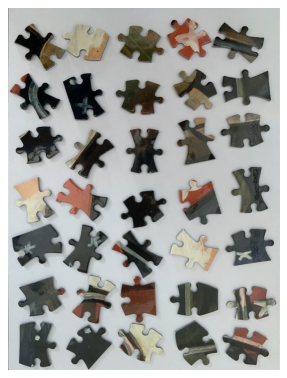

In [14]:
show(img_balanced)

In [62]:
blurred = blur(img_balanced)
hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
h,s,v = cv2.split(hsv)

edges = cv2.threshold(s, 20, 100, cv2.THRESH_BINARY_INV)[1]

contour_info = [(c, cv2.contourArea(c),) for c in cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)[0]]

image_area = img_balanced.shape[0] * img_balanced.shape[1]  
max_area = 0.50
max_area = max_area * image_area

mask = np.ones(edges.shape, dtype = np.uint8)*255
for contour in contour_info:
    if contour[1] < max_area:
        mask = cv2.fillConvexPoly(mask, contour[0], (0))

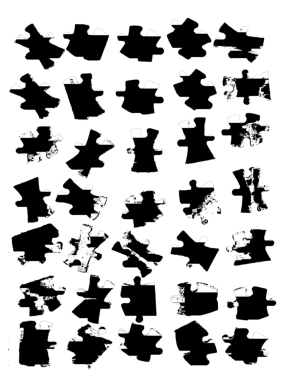

In [63]:
show(mask)

In [64]:
colors = []
for _ in range(20000):
    i, j = np.random.randint(0, len(mask)), np.random.randint(0, len(mask[0]))
    if mask[i][j] > 0:
        colors.append(img_balanced[i][j])
        
c_var = np.var(colors, axis=0)

In [65]:
from sklearn.cluster import KMeans

def centroid_histogram(clt):
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    hist = hist.astype("float")
    hist /= hist.sum()
    return hist

def plot_colors(hist, centroids):
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0
    for (percent, color) in zip(hist, centroids):
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
            color.astype("uint8").tolist(), -1)
        startX = endX
    return bar

In [66]:
clt = KMeans(n_clusters = 30)
clt.fit(colors)
hist = centroid_histogram(clt)
bar = plot_colors(hist, clt.cluster_centers_)

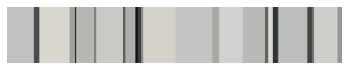

In [67]:
plt.figure()
plt.axis("off")
plt.imshow(bar)
plt.show()

In [68]:
img_overlap = np.zeros(mask.shape, dtype = "uint8")
for c_mean in clt.cluster_centers_:
    m = cv2.inRange(img_balanced, c_mean-0.2*np.sqrt(c_var), c_mean+0.2*np.sqrt(c_var))
    v = np.sum((255-m == 0)*(255-mask == 0))/np.sum((255-m == 0))
    # verify the color not in the puzzle blocks
    if v > 0.8:
        img_overlap |= m

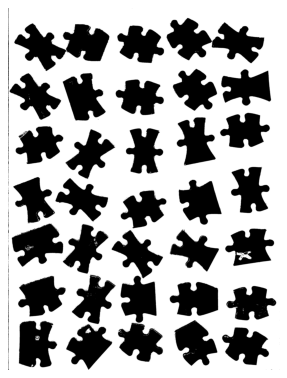

In [69]:
show(img_overlap)

In [70]:
kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
bin_clo = cv2.dilate(img_overlap, kernel2, iterations=1)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(255-bin_clo, connectivity=4)

# print('num_labels = ',num_labels)
# 连通域的信息：对应各个轮廓的x、y、width、height和面积
# print('stats = ',stats)
# 连通域的中心点
# print('centroids = ',centroids)
# 每一个像素的标签1、2、3.。。，同一个连通域的标签是一致的
# print('labels = ',labels)

# 不同的连通域赋予不同的颜色
output = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)
for i in range(1, num_labels):

    m = labels == i
    output[:, :, 0][m] = np.random.randint(0, 255)
    output[:, :, 1][m] = np.random.randint(0, 255)
    output[:, :, 2][m] = np.random.randint(0, 255)

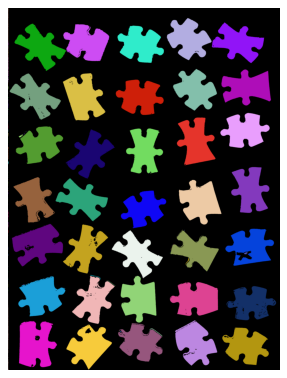

In [71]:
show(output)

In [30]:
output = cv2.connectedComponentsWithStats(255-img_overlap, 4, cv2.CV_32S)

In [31]:
img_temp = img_balanced.copy()

In [32]:
margin = 100

num_labels = output[0]
labels = output[1]
stats = output[2]
centroids = output[3]

unique, counts = np.unique(labels, return_counts=True) #is sorted
unique = unique[1:]
counts = counts[1:]

q75, q25 = np.percentile(counts, [75 ,25])
iqr = q75 - q25
low = q25
hi = q75

clean_labels = []
clean_counts = []
for i in range(len(counts)):
    if low < counts[i] < hi:
        clean_labels.append(unique[i])
        clean_counts.append(counts[i])
boxes = []
for i in range(1,num_labels):
    if i not in clean_labels:
        continue
    x, y = stats[i,cv2.CC_STAT_LEFT], stats[i,cv2.CC_STAT_TOP]
    w, h = stats[i,cv2.CC_STAT_WIDTH], stats[i,cv2.CC_STAT_HEIGHT]
    box = ((x-(h-w)/2-margin,y-margin), (x+h+margin-(h-w)/2, y+h+margin)) if h > w else \
        ((x - margin, y - margin - (w-h) / 2), (x + w + margin, y + w + margin - (w-h) / 2))
    boxes.append(box)

for box in boxes:
    img_temp = cv2.rectangle(img_temp, tuple([int(x) for x in box[0]]), tuple([int(x) for x in box[1]]), thickness=2, color=[255,0,0])
    

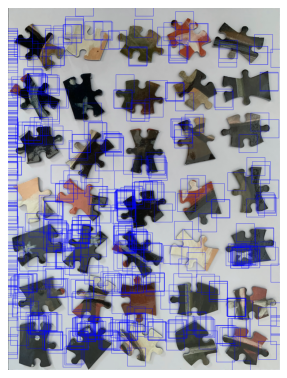

In [33]:
show(img_temp)

In [4]:
img_path = img_paths[0]

img = cv2.imread(img_path)
orig_width = len(img[0])
orig_height = len(img)
target = 800
scale = target/orig_width if orig_height > orig_width else target/orig_height

resized = cv2.resize(img, None, fx=scale, fy=scale)
img_balanced = white_balance(resized)

In [28]:
blurred = blur(img_balanced)

gray   = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
# thresh = cv2.threshold(gray, 130, 255, cv2.THRESH_BINARY)[1]
canny_low = 20
canny_high = 120
edges = cv2.Canny(gray, canny_low, canny_high)
for i in range(2):
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)
contour_info = [(c, cv2.contourArea(c),) for c in cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)[0]]

In [29]:
blurred = blur(img_balanced)
hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
h,s,v = cv2.split(hsv)

edges = cv2.threshold(s, 16, 255, cv2.THRESH_BINARY_INV)[1]

mask = cv2.erode(edges, None, iterations=3)
mask = cv2.dilate(mask, None, iterations=3)
contour_info = [(c, cv2.contourArea(c),) for c in cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)[0]]

In [8]:
connectivity=4
output = cv2.connectedComponentsWithStats(edges, connectivity, cv2.CV_32S)

In [109]:
image_area = img_balanced.shape[0] * img_balanced.shape[1]  

min_area = 0.0001
max_area = 0.90

max_area = max_area * image_area
min_area = min_area * image_area

mask = np.zeros(edges.shape, dtype = np.uint8)
for contour in contour_info:
        if contour[1] > min_area and contour[1] < max_area:
            mask = cv2.fillConvexPoly(mask, contour[0], (255))

In [214]:
canny = cv2.Canny(mask, 100, 255, 1)
corners = cv2.goodFeaturesToTrack(canny, 20, 0.1, 100)
corners = [tuple(corner.flatten()) for corner in corners]
tile_center = ndimage.center_of_mass(mask)
tile_center = tuple(np.round(tile_center).astype(np.int))

In [206]:
corners = get_tile_corners(mask)

In [151]:
def annotate(img_path, connectivity=8, margin=5):
    img = cv2.imread(img_path)
    orig_width = len(img[0])
    orig_height = len(img)
    target = 800
    scale = target/orig_width if orig_height > orig_width else target/orig_height

    resized = cv2.resize(img, None, fx=scale, fy=scale)
    img_balanced = white_balance(resized)
    
    blurred = blur(img_balanced)

    gray   = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    canny_low = 20
    canny_high = 100
    edges = cv2.Canny(gray, canny_low, canny_high)
    for i in range(1):
        edges = cv2.dilate(edges, None)
        edges = cv2.erode(edges, None)

    output = cv2.connectedComponentsWithStats(edges, connectivity, cv2.CV_32S)

    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]

    unique, counts = np.unique(labels, return_counts=True) #is sorted
    unique = unique[1:]
    counts = counts[1:]

    q75, q25 = np.percentile(counts, [100 ,50])
    iqr = q75 - q25
    low = q25
    hi = q75

    clean_labels = []
    clean_counts = []
    for i in range(len(counts)):
        if low < counts[i] < hi:
            clean_labels.append(unique[i])
            clean_counts.append(counts[i])
    boxes = []
    for i in range(1,num_labels):
        if i not in clean_labels:
            continue
        x, y = stats[i,cv2.CC_STAT_LEFT], stats[i,cv2.CC_STAT_TOP]
        w, h = stats[i,cv2.CC_STAT_WIDTH], stats[i,cv2.CC_STAT_HEIGHT]
        box = ((x-(h-w)/2-margin,y-margin), (x+h+margin-(h-w)/2, y+h+margin)) if h > w else \
            ((x - margin, y - margin - (w-h) / 2), (x + w + margin, y + w + margin - (w-h) / 2))
        boxes.append(box)
        
    for box in boxes:
        img_balanced = cv2.rectangle(img_balanced, tuple([int(x) for x in box[0]]), tuple([int(x) for x in box[1]]), thickness=2, color=[255,0,0])
    return img_balanced, boxes

In [152]:
img, boxes = annotate(img_path)

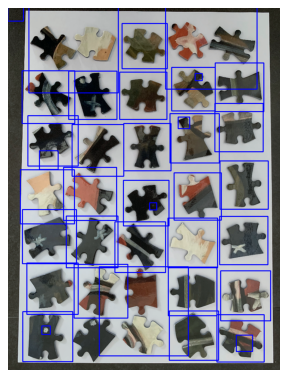

In [153]:
show(img)